#### Import Libraries

In [40]:
# == Standard libraries == # 
import os 
import random 
import numpy as np 
from PIL import Image 
from types import SimpleNamespace

# == Imports for plotting == # 
import matplotlib.pyplot as plt 
%matplotlib inline 

# == PyTorch == # 
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 

# == Torchvision == # 
import torchvision

In [3]:
# Function for setting the seed
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

torch.manual_seed(42)


# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

### Data Preparation

In [6]:
from torchvision.datasets import CIFAR10 
import torchvision.transforms as T 

DATASET_PATH = "./dataset/"


# === download dataset object === # 
train_data = CIFAR10 (  root=DATASET_PATH + "train",
                        train=True,
                        download=True,
                        )

test_data = CIFAR10 (   root=DATASET_PATH + "test",
                        train=False,
                        download=True, 
                        )  

DATA_MEANS = (train_data.data / 255.0).mean(axis=(0,1,2))
DATA_STD = (train_data.data / 255.0).std(axis=(0,1,2))


print(f"Data mean: {DATA_MEANS}")
print(f"Data std: {DATA_STD}")


# === data transformation === # 
train_T = T.Compose([   T.RandomCrop(32, padding=4),
                        T.RandomHorizontalFlip(), 
                        T.ToTensor(), 
                        T.Normalize(mean= DATA_MEANS,
                                    std=DATA_STD),
                    ])

test_T = T.Compose([    T.ToTensor(),
                        T.Normalize(mean= DATA_MEANS,
                                    std=DATA_STD)
                    ])    


Files already downloaded and verified
Files already downloaded and verified
Data mean: [0.49139968 0.48215841 0.44653091]
Data std: [0.24703223 0.24348513 0.26158784]


In [21]:
print(train_data)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./dataset/train
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.49139968 0.48215841 0.44653091], std=[0.24703223 0.24348513 0.26158784])
           )


In [11]:
from torch.utils.data.dataset import random_split

# === download dataset object === # 
train_data = CIFAR10 (  root=DATASET_PATH + "train",
                        train=True,
                        transform=train_T,
                        download=True,
                        )

val_data = CIFAR10 (  root=DATASET_PATH + "train",
                        train=True,
                        transform=test_T,
                        download=True,
                        )

set_seed(42)

test_set = CIFAR10 (   root=DATASET_PATH + "test",
                        train=False,
                        transform=test_T,
                        download=True, 
                        )  


# === Random Split for training === # 
# (ref) https://wikidocs.net/73569

train_set, _ = random_split(train_data, [45000, 5000])
set_seed(42) # reset 
_, val_set = random_split(val_data, [45000, 5000])

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


#### Data Batching

In [14]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_set,
                        batch_size=128,
                        shuffle=True, 
                        drop_last=True,
                        pin_memory=True, 
                        num_workers=4 )

val_loader = DataLoader(val_set, 
                        batch_size=128, 
                        shuffle=False, 
                        drop_last=False, 
                        num_workers=4)

test_loader = DataLoader(test_set, 
                        batch_size=128, 
                        shuffle=False, 
                        drop_last=False, 
                        num_workers=4)                        

In [18]:
# === Check the normalization === # 
imgs, label = next(iter(train_loader))
print("Batch mean", imgs.mean(dim=[0,2,3]))
print("Batch std", imgs.std(dim=[0,2,3]))

Batch mean tensor([-0.2291, -0.2545, -0.2075])
Batch std tensor([1.1510, 1.1581, 1.1079])


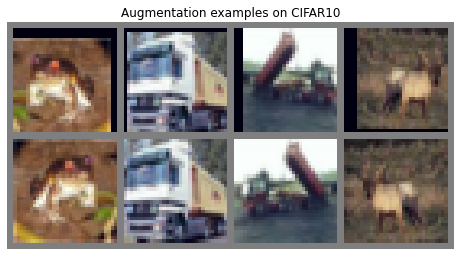

In [24]:
# === Visualize a few images === # 
NUM_IMAGES = 4
images = [train_data[idx][0] for idx in range(NUM_IMAGES)]
orig_images = [Image.fromarray(train_data.data[idx]) for idx in range(NUM_IMAGES)]
orig_images = [test_T(img) for img in orig_images]

img_grid = torchvision.utils.make_grid(torch.stack(images + orig_images, dim=0), nrow=4, normalize=True, pad_value=0.5)
img_grid = img_grid.permute(1, 2, 0)  # (C, H, W) -> (H, W, C) for visualization 

plt.figure(figsize=(8,8))
plt.title("Augmentation examples on CIFAR10")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

## PyTorch Lightning 
[PyTorch Lightning](https://www.pytorchlightning.ai/)는 코드를 좀더 단순화 시켜 아래 기능을 구현할 수 있음: <br/>

* ```train``` block 
* ```evaluate``` block 
* ```test``` block 
* loggin into [TensorBoard](https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html)
* visualization toolkit for ML experiments
* saving model checkpoints
* etc

<br/>

유효성 : 
* 덕분에 model architectures 구현에 시간을 더 투자할 수 있음 

In [29]:
# == PyTorch Lightning == # 
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl

In [30]:
# == PyTorch Lightning comes with a lot of useful functions, such as one for setting the seed:  # 
pl.seed_everything(42)

Global seed set to 42


42

PyTorch Lightning의 핵심 모듈인 `pl.LightningModule` (inheriting from `torch.nn.Module`) 은 5가지 메인 섹션으로 구성된다: 
1. Initialization (`__init__`) - to create all necessary parameters/models
2. Optimizers (`configure_optimizers`) - to create the optimizers, learning rate scheduler, etc. 
3. Training loop (`training_step`) - to define the loss calculation for a single batch <br/> 
(the loop of `optimizer.zero_grad()`, `loss.backward()` and `optimizer.step()`, as well as any `logging/saving operation`, is done in the background)
4. Validation loop (`validation_step`) - similarly to the training, we only have to define what should happen per step
5. Test loop (`test_step`) - the same as validation, only on a test set.

In [31]:
# ==  Lightning Module for training == # 
# (ref) https://pytorch-lightning.readthedocs.io/en/latest/notebooks/course_UvA-DL/04-inception-resnet-densenet.html


class CIFARModule(pl.LightningModule):

    def __init__(self, model_name, model_hparams, optimizer_name, optimizer_hparams):
        """
        Inputs:
            model_name - Name of the model/CNN to run. Used for creating the model (see function below)
            model_hparams - Hyperparameters for the model, as dictionary.
            optimizer_name - Name of the optimizer to use. Currently supported: Adam, SGD
            optimizer_hparams - Hyperparameters for the optimizer, as dictionary. This includes learning rate, weight decay, etc.
        """
        super().__init__()
        # Exports the hyperparameters to a YAML file, and create "self.hparams" namespace
        self.save_hyperparameters()
        # Create model
        self.model = create_model(model_name, model_hparams)
        # Create loss module
        self.loss_module = nn.CrossEntropyLoss()
        # Example input for visualizing the graph in Tensorboard
        self.example_input_array = torch.zeros((1, 3, 32, 32), dtype=torch.float32)


    def forward(self, imgs):
        # Forward function that is run when visualizing the graph
        return self.model(imgs)


    def configure_optimizers(self):
        # We will support Adam or SGD as optimizers.
        if self.hparams.optimizer_name == "Adam":
            # AdamW is Adam with a correct implementation of weight decay (see here for details: https://arxiv.org/pdf/1711.05101.pdf)
            optimizer = optim.AdamW( self.parameters(), **self.hparams.optimizer_hparams)

        elif self.hparams.optimizer_name == "SGD":
            optimizer = optim.SGD(self.parameters(), **self.hparams.optimizer_hparams)

        else:
            assert False, f"Unknown optimizer: \"{self.hparams.optimizer_name}\""

        # We will reduce the learning rate by 0.1 after 100 and 150 epochs
        scheduler = optim.lr_scheduler.MultiStepLR(
            optimizer, milestones=[100, 150], gamma=0.1)
        return [optimizer], [scheduler]



    def training_step(self, batch, batch_idx):
        # "batch" is the output of the training data loader.
        imgs, labels = batch
        preds = self.model(imgs)
        loss = self.loss_module(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        # Logs the accuracy per epoch to tensorboard (weighted average over batches)
        self.log('train_acc', acc, on_step=False, on_epoch=True)
        self.log('train_loss', loss)
        return loss  # Return tensor to call ".backward" on



    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)
        acc = (labels == preds).float().mean()
        # By default logs it per epoch (weighted average over batches)
        self.log('val_acc', acc)


    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)
        acc = (labels == preds).float().mean()
        # By default logs it per epoch (weighted average over batches), and returns it afterwards
        self.log('test_acc', acc)

In [33]:
# Callbacks 
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

model_dict = {}

def create_model(model_name, model_hparams):
    if model_name in model_dict:
        return model_dict[model_name](**model_hparams)
    else:
        assert False, f"Unknown model name \"{model_name}\". Available models are: {str(model_dict.keys())}"

In [37]:

CHECKPOINT_PATH = "./saved_models"

def train_model(model_name, save_name=None, **kwargs):
    """
    Inputs:
        model_name - Name of the model you want to run. Is used to look up the class in "model_dict"
        save_name (optional) - If specified, this name will be used for creating the checkpoint and logging directory.
    """
    if save_name is None:
        save_name = model_name
        
    # == Create a PyTorch Lightning trainer with the generation callback == # 
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, save_name),                          # Where to save models
                         gpus=1 if str(device)=="cuda:0" else 0,                                             # We run on a single GPU (if possible)
                         max_epochs=180,                                                                     # How many epochs to train for if no patience is set
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),  # Save the best checkpoint based on the maximum val_acc recorded. Saves only weights and not optimizer
                                    LearningRateMonitor("epoch")],                                           # Log learning rate every epoch
                         progress_bar_refresh_rate=1)                                                        # In case your notebook crashes due to the progress bar, consider increasing the refresh rate
    trainer.logger._log_graph = True         # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need
    

    # == Check whether pretrained model exists. If yes, load it and skip training == # 
    pretrained_filename = os.path.join(CHECKPOINT_PATH, save_name + ".ckpt")
    
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = CIFARModule.load_from_checkpoint(pretrained_filename) # Automatically loads the model with the saved hyperparameters
    else:
        pl.seed_everything(42) # To be reproducable
        model = CIFARModule(model_name=model_name, **kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = CIFARModule.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training
        
    # == Test best model on validation and test set == # 
    val_result = trainer.test(model, test_dataloaders=val_loader, verbose=False)
    test_result = trainer.test(model, test_dataloaders=test_loader, verbose=False)
    result = {"test": test_result[0]["test_acc"], "val": val_result[0]["test_acc"]}
    
    return model, result

## Model Designs

### Pretrained models and Tensorboards 

In [39]:
import urllib.request
from urllib.error import HTTPError

# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial5/"

# Files to download
pretrained_files = ["GoogleNet.ckpt", "ResNet.ckpt", "ResNetPreAct.ckpt", "DenseNet.ckpt",
                    "tensorboards/GoogleNet/events.out.tfevents.googlenet",
                    "tensorboards/ResNet/events.out.tfevents.resnet",
                    "tensorboards/ResNetPreAct/events.out.tfevents.resnetpreact",
                    "tensorboards/DenseNet/events.out.tfevents.densenet"]

# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

In [26]:
act_fn_by_name = {
    "tanh": nn.Tanh,
    "relu": nn.ReLU,
    "leakyrelu": nn.LeakyReLU,
    "gelu": nn.GELU
}

### Inception
<center width="100%"><img src="./imgs/inception_block.svg" style="display: block; margin-left: auto; margin-right: auto;" width="500px"/></center>

In [25]:
class InceptionBlock(nn.Module):
    
    def __init__(self, c_in, c_red : dict, c_out : dict, act_fn):
        """
        Inputs:
            c_in - Number of input feature maps from the previous layers
            c_red - Dictionary with keys "3x3" and "5x5" specifying the output of the dimensionality reducing 1x1 convolutions
            c_out - Dictionary with keys "1x1", "3x3", "5x5", and "max"
            act_fn - Activation class constructor (e.g. nn.ReLU)
        """
        super(InceptionBlock, self).__init__()
        
        # 1x1 convolution branch
        self.conv_1x1 = nn.Sequential(  nn.Conv2d(c_in, c_out["1x1"], kernel_size=1),
                                        nn.BatchNorm2d(c_out["1x1"]),
                                        act_fn(),
                                    )
        
        # 3x3 convolution branch
        self.conv_3x3 = nn.Sequential(  nn.Conv2d(c_in, c_red["3x3"], kernel_size=1),
                                        nn.BatchNorm2d(c_red["3x3"]),
                                        act_fn(),
                                        nn.Conv2d(c_red["3x3"], c_out["3x3"], kernel_size=3, padding=1),
                                        nn.BatchNorm2d(c_out["3x3"]),
                                        act_fn(),
                                    )
        
        # 5x5 convolution branch
        self.conv_5x5 = nn.Sequential(  nn.Conv2d(c_in, c_red["5x5"], kernel_size=1),
                                        nn.BatchNorm2d(c_red["5x5"]),
                                        act_fn(),
                                        nn.Conv2d(c_red["5x5"], c_out["5x5"], kernel_size=5, padding=2),
                                        nn.BatchNorm2d(c_out["5x5"]),
                                        act_fn(),
                                    )
        
        # Max-pool branch
        self.max_pool = nn.Sequential(  nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
                                        nn.Conv2d(c_in, c_out["max"], kernel_size=1),
                                        nn.BatchNorm2d(c_out["max"]),
                                        act_fn(),
                                    )

    def forward(self, x):
        x_1x1 = self.conv_1x1(x)
        x_3x3 = self.conv_3x3(x)
        x_5x5 = self.conv_5x5(x)
        x_max = self.max_pool(x)
        x_out = torch.cat([x_1x1, x_3x3, x_5x5, x_max], dim=1)
        return x_out

In [27]:
class GoogleNet(nn.Module):

    def __init__(self, num_classes=10, act_fn_name="relu", **kwargs):
        super().__init__()
        self.hparams = SimpleNamespace( num_classes = num_classes,
                                        act_fn_name = act_fn_name,
                                        act_fn = act_fn_by_name[act_fn_name]
                                    )
        self._create_network()
        self._init_params()

    def _create_network(self):
        # A first convolution on the original image to scale up the channel size
        self.input_net = nn.Sequential( nn.Conv2d(3, 64, kernel_size=3, padding=1),
                                        nn.BatchNorm2d(64),
                                        self.hparams.act_fn()
                                        )
        # Stacking inception blocks
        self.inception_blocks = nn.Sequential(
                        InceptionBlock(64, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 32, "5x5": 8, "max": 8}, act_fn=self.hparams.act_fn),
                        InceptionBlock(64, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 24, "3x3": 48, "5x5": 12, "max": 12}, act_fn=self.hparams.act_fn),
                        nn.MaxPool2d(3, stride=2, padding=1),  # 32x32 => 16x16

                        InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 24, "3x3": 48, "5x5": 12, "max": 12}, act_fn=self.hparams.act_fn),
                        InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 48, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn),
                        InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 48, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn),
                        InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 32, "3x3": 48, "5x5": 24, "max": 24}, act_fn=self.hparams.act_fn),
                        nn.MaxPool2d(3, stride=2, padding=1),  # 16x16 => 8x8

                        InceptionBlock(128, c_red={"3x3": 48, "5x5": 16}, c_out={"1x1": 32, "3x3": 64, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn),
                        InceptionBlock(128, c_red={"3x3": 48, "5x5": 16}, c_out={"1x1": 32, "3x3": 64, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn)
                    )

        # Mapping to classification output
        self.output_net = nn.Sequential(
                        nn.AdaptiveAvgPool2d((1, 1)),
                        nn.Flatten(),
                        nn.Linear(128, self.hparams.num_classes)
                    )

    def _init_params(self):
        # Based on our discussion in Tutorial 4, we should initialize the convolutions according to the activation function
        # (ref) https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial4/Optimization_and_Initialization.html
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_( m.weight, 
                                        nonlinearity=self.hparams.act_fn_name)

            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.input_net(x)
        x = self.inception_blocks(x)
        x = self.output_net(x)
        return x

In [35]:
model_dict["GoogleNet"] = GoogleNet

In [38]:
googlenet_model, googlenet_results = train_model(model_name="GoogleNet", 
                                                 model_hparams={"num_classes": 10, 
                                                                "act_fn_name": "relu"}, 
                                                 optimizer_name="Adam",
                                                 optimizer_hparams={"lr": 1e-3,
                                                                    "weight_decay": 1e-4})

/home/milky/anaconda3/envs/py38/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:90: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=1)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/milky/anaconda3/envs/py38/lib/python3.8/site-packages/torch/_jit_internal.py:668: LightningDeprecationWarning: The `LightningModule.loaded_optimizer_states_dict` property is deprecated in v1.4 and will be removed in v1.6.
  if hasattr(mod, name):

  | Name        | Type             | Params | In sizes       | Out sizes

Global seed set to 42


Epoch 179: 100%|██████████| 391/391 [00:22<00:00, 17.07it/s, loss=0.00612, v_num=0]

/home/milky/anaconda3/envs/py38/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:906: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing: 100%|██████████| 40/40 [00:00<00:00, 58.46it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing: 100%|██████████| 79/79 [00:01<00:00, 69.18it/s]


In [41]:
print("GoogleNet Results", googlenet_results)

GoogleNet Results {'test': 0.8999000191688538, 'val': 0.9056000113487244}


### Tensorboard Log 

In [46]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export

/tmp/ipykernel_18851/3879281233.py:2: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [47]:
# Load tensorboard extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [48]:
# Opens tensorboard in notebook. Adjust the path to your CHECKPOINT_PATH!
%tensorboard --logdir ./saved_models/tensorboards/GoogleNet/

Reusing TensorBoard on port 6008 (pid 138576), started 0:00:37 ago. (Use '!kill 138576' to kill it.)